In [1]:
import os
# Java 8 path
os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/temurin-8.jdk/Contents/Home'

# PySpark path
os.environ['SPARK_HOME'] = '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark'

In [2]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Time Table Analaysis") \
    .getOrCreate()

26/01/31 11:32:11 WARN Utils: Your hostname, Dikshantas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.25.0.81 instead (on interface en0)
26/01/31 11:32:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/31 11:32:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Ingestion and Storage

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Load the CSV file
df = spark.read.csv('/Users/dikshanta/Desktop/Falcon Buses_237/combined.csv', header=True, inferSchema=True)

# Display basic information
print("Dataset loaded successfully")
print(f"Total rows: {df.count()}")
print(f"Total columns: {len(df.columns)}")

# Show schema
print("\nSchema:")
df.printSchema()

# Display first 5 rows
print("\nFirst 5 rows:")
df.show(5, truncate=False)

Dataset loaded successfully
Total rows: 81762
Total columns: 20

Schema:
root
 |-- FileName: string (nullable = true)
 |-- OperatorName: string (nullable = true)
 |-- LineName: string (nullable = true)
 |-- Direction: string (nullable = true)
 |-- DepartureTime: timestamp (nullable = true)
 |-- JourneyCode: string (nullable = true)
 |-- Sequence: integer (nullable = true)
 |-- Activity: string (nullable = true)
 |-- TimingStatus: string (nullable = true)
 |-- RunTime: string (nullable = true)
 |-- FromStopRef: string (nullable = true)
 |-- FromStopName: string (nullable = true)
 |-- FromLat: double (nullable = true)
 |-- FromLon: double (nullable = true)
 |-- ToStopRef: string (nullable = true)
 |-- ToStopName: string (nullable = true)
 |-- ToLat: double (nullable = true)
 |-- ToLon: double (nullable = true)
 |-- SchoolOrgName: string (nullable = true)
 |-- OperatingDates: string (nullable = true)


First 5 rows:
+---------------------------------------------------------+--------------

## Data Ingestion - Converted To Pandas 

In [10]:
import pandas as pd

# Convert PySpark DataFrame to Pandas
pdf = df.toPandas()

# Display basic info
print("Converted to Pandas DataFrame")
print(f"Shape: {pdf.shape}")
print(f"Rows: {pdf.shape[0]}, Columns: {pdf.shape[1]}")

# Set pandas display options for better table formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Display first 5 rows in tabular format
print("\nFirst 5 rows:")
print(pdf.head(5))

# Alternative: Display as a nice table
print("\nColumn names:")
print(pdf.columns.tolist())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Converted to Pandas DataFrame
Shape: (81762, 20)
Rows: 81762, Columns: 20

First 5 rows:
                                            FileName        OperatorName  \
0  FALC_663_FALCPK110996920663_20240901_20250831_...  Falcon Coaches Ltd   
1  FALC_663_FALCPK110996920663_20240901_20250831_...  Falcon Coaches Ltd   
2  FALC_663_FALCPK110996920663_20240901_20250831_...  Falcon Coaches Ltd   
3  FALC_663_FALCPK110996920663_20240901_20250831_...  Falcon Coaches Ltd   
4  FALC_663_FALCPK110996920663_20240901_20250831_...  Falcon Coaches Ltd   

  LineName Direction       DepartureTime JourneyCode  Sequence Activity  \
0      663  outbound 2026-01-31 07:35:00        0735         1   pickUp   
1      663  outbound 2026-01-31 07:35:00        0735         2     None   
2      663  outbound 2026-01-31 07:35:00        0735         3     None   
3      663  outbound 2026-01-31 07:35:00        0735         4     None   
4      663  outbound 2026-01-31 07:35:00        0735         5     None   

   

## Data Clearning and Preprocessing 

In [11]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
import numpy as np

print("=" * 70)
print("DATA CLEANING & PREPROCESSING")
print("=" * 70)

# 1. CLEAN RUNTIME - Convert PT1M to 1.0 minutes
print("\nStep 1: Converting RunTime to minutes...")
df_clean = df.withColumn(
    'RunTime_Minutes',
    regexp_extract(col('RunTime'), r'PT(\d+)M', 1).cast('double')
)
df_clean = df_clean.na.fill({'RunTime_Minutes': 0.0})
print("Runtime converted")

# 2. CALCULATE DISTANCE using Haversine formula
print("\nStep 2: Calculating distance between stops...")
df_clean = df_clean.withColumn(
    'FromLat_rad', radians(col('FromLat'))
).withColumn(
    'FromLon_rad', radians(col('FromLon'))
).withColumn(
    'ToLat_rad', radians(col('ToLat'))
).withColumn(
    'ToLon_rad', radians(col('ToLon'))
).withColumn(
    'dlat', col('ToLat_rad') - col('FromLat_rad')
).withColumn(
    'dlon', col('ToLon_rad') - col('FromLon_rad')
).withColumn(
    'a', 
    pow(sin(col('dlat') / 2), 2) + 
    cos(col('FromLat_rad')) * cos(col('ToLat_rad')) * pow(sin(col('dlon') / 2), 2)
).withColumn(
    'c', 2 * asin(sqrt(col('a')))
).withColumn(
    'Distance_km', 6371 * col('c')
).drop('FromLat_rad', 'FromLon_rad', 'ToLat_rad', 'ToLon_rad', 'dlat', 'dlon', 'a', 'c')

print("Distance calculated")

# 3. EXTRACT TIME FEATURES
print("\nStep 3: Extracting time features...")
df_clean = df_clean.withColumn(
    'Hour', hour(to_timestamp(col('DepartureTime'), 'HH:mm:ss'))
).withColumn(
    'Minute', minute(to_timestamp(col('DepartureTime'), 'HH:mm:ss'))
).withColumn(
    'IsRushHour', 
    when((col('Hour').between(7, 9)) | (col('Hour').between(16, 18)), 1).otherwise(0)
)
print("Time features extracted")

# 4. FILTER VALID DATA - Remove invalid rows
print("\nStep 4: Filtering valid data...")
df_clean = df_clean.filter(
    (col('RunTime_Minutes') > 0) & 
    (col('RunTime_Minutes').isNotNull()) &
    (col('Distance_km').isNotNull())
)
total_clean = df_clean.count()
print(f"Valid records: {total_clean}")

# 5. ENCODE CATEGORICAL VARIABLES
print("\nStep 5: Encoding categorical features...")
indexer_line = StringIndexer(inputCol='LineName', outputCol='LineName_Encoded', handleInvalid='keep')
indexer_direction = StringIndexer(inputCol='Direction', outputCol='Direction_Encoded', handleInvalid='keep')
indexer_timing = StringIndexer(inputCol='TimingStatus', outputCol='TimingStatus_Encoded', handleInvalid='keep')

df_clean = indexer_line.fit(df_clean).transform(df_clean)
df_clean = indexer_direction.fit(df_clean).transform(df_clean)
df_clean = indexer_timing.fit(df_clean).transform(df_clean)
print("Categorical encoding complete")

# 6. SELECT FINAL FEATURES
print("\nStep 6: Selecting features for modeling...")
feature_cols = [
    'LineName_Encoded',
    'Direction_Encoded',
    'Sequence',
    'TimingStatus_Encoded',
    'Distance_km',
    'Hour',
    'IsRushHour',
    'FromLat',
    'FromLon',
    'ToLat',
    'ToLon'
]

# Drop rows with any null values in feature columns
df_final = df_clean.select(feature_cols + ['RunTime_Minutes']).na.drop()
print(f"Final dataset: {df_final.count()} rows")

# 7. ASSEMBLE FEATURES INTO VECTOR
print("\nStep 7: Assembling feature vector...")
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_raw')
df_assembled = assembler.transform(df_final)

# 8. STANDARDIZE FEATURES (Normalization)
print("\nStep 8: Standardizing features...")
scaler = StandardScaler(inputCol='features_raw', outputCol='features', withMean=True, withStd=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

print("\nPreprocessing complete!")

# SHOW PROCESSED DATA
print("\n" + "=" * 70)
print("PROCESSED DATA - FIRST 5 ROWS")
print("=" * 70)

# Convert to Pandas for better display
processed_display = df_scaled.select(
    'LineName_Encoded',
    'Direction_Encoded',
    'Distance_km',
    'Hour',
    'IsRushHour',
    'RunTime_Minutes'
).limit(5).toPandas()

print("\nSample of processed features:")
print(processed_display.to_string(index=False))

# Show statistics
print("\n" + "=" * 70)
print("FEATURE STATISTICS")
print("=" * 70)
df_scaled.select(
    'Distance_km',
    'Hour',
    'Sequence',
    'RunTime_Minutes'
).describe().show()

print("\nData is now ready for machine learning!")

DATA CLEANING & PREPROCESSING

Step 1: Converting RunTime to minutes...
Runtime converted

Step 2: Calculating distance between stops...
Distance calculated

Step 3: Extracting time features...
Time features extracted

Step 4: Filtering valid data...
Valid records: 69273

Step 5: Encoding categorical features...


Categorical encoding complete

Step 6: Selecting features for modeling...
Final dataset: 69273 rows

Step 7: Assembling feature vector...

Step 8: Standardizing features...



Preprocessing complete!

PROCESSED DATA - FIRST 5 ROWS

Sample of processed features:
 LineName_Encoded  Direction_Encoded  Distance_km  Hour  IsRushHour  RunTime_Minutes
             20.0                0.0     0.420650     7           1              1.0
             20.0                0.0     0.223058     7           1              2.0
             20.0                0.0     0.332701     7           1              1.0
             20.0                0.0     0.205683     7           1              1.0
             20.0                0.0     0.240081     7           1              1.0

FEATURE STATISTICS


26/01/31 11:46:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+------------------+------------------+
|summary|        Distance_km|              Hour|          Sequence|   RunTime_Minutes|
+-------+-------------------+------------------+------------------+------------------+
|  count|              69273|             69273|             69273|             69273|
|   mean|0.41111446903042465|12.652577483290749|27.367704589089545|1.4065941997603684|
| stddev|0.32569573749729486| 3.769623909217116|16.929610217369483|0.8634032865083658|
|    min|0.04527621788279501|                 5|                 1|               1.0|
|    max|  6.211523431132325|                23|                83|              13.0|
+-------+-------------------+------------------+------------------+------------------+


Data is now ready for machine learning!


# Train - Test - Dataset

RANDOM FOREST REGRESSOR - TRAINING & EVALUATION

Step 1: Splitting data into train and test sets...
Training set: 55605 samples (80%)
Test set: 13668 samples (20%)

Step 2: Creating Random Forest model...
Model configuration:
  Number of trees: 100
  Max depth: 15
  Min instances per node: 5

Step 3: Training Random Forest model...
(This may take 1-2 minutes...)


26/01/31 11:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
26/01/31 11:59:40 WARN DAGScheduler: Broadcasting large task binary with size 1675.0 KiB
26/01/31 11:59:40 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
26/01/31 11:59:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/01/31 11:59:43 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
26/01/31 11:59:43 WARN DAGScheduler: Broadcasting large task binary with size 1081.6 KiB
26/01/31 11:59:44 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
26/01/31 11:59:45 WARN DAGScheduler: Broadcasting large task binary with size 1347.3 KiB
26/01/31 11:59:46 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
26/01/31 11:59:47 WARN DAGScheduler: Broadcasting large task binary with size 1617.7 KiB
26/01/31 11:59:48 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
26/01/31 11:59:50 WARN DAGScheduler: 

Training complete!
Feature importances calculated

Step 4: Making predictions on test data...
Generated 13668 predictions

MODEL EVALUATION METRICS

Mean Absolute Error (MAE):  0.1458 minutes
Root Mean Squared Error:    0.2920 minutes
R-Squared Score:            0.8792

Interpretation:
  Average prediction error: 0.146 minutes (8.7 seconds)
  Model explains 87.9% of the variance
  Model quality: EXCELLENT

SAMPLE PREDICTIONS (First 10)

  Actual  Predicted    Error
    1.0   1.435562 0.435562
    1.0   1.537147 0.537147
    1.0   1.537147 0.537147
    2.0   1.811024 0.188976
    2.0   1.830709 0.169291
    2.0   1.854552 0.145448
    2.0   1.854552 0.145448
    2.0   1.854552 0.145448
    2.0   1.854552 0.145448
    2.0   1.854552 0.145448

FEATURE IMPORTANCE

Top features by importance:
             Feature  Importance
         Distance_km    0.339276
            Sequence    0.109392
               ToLon    0.107462
               ToLat    0.099016
             FromLat    0.098213
   

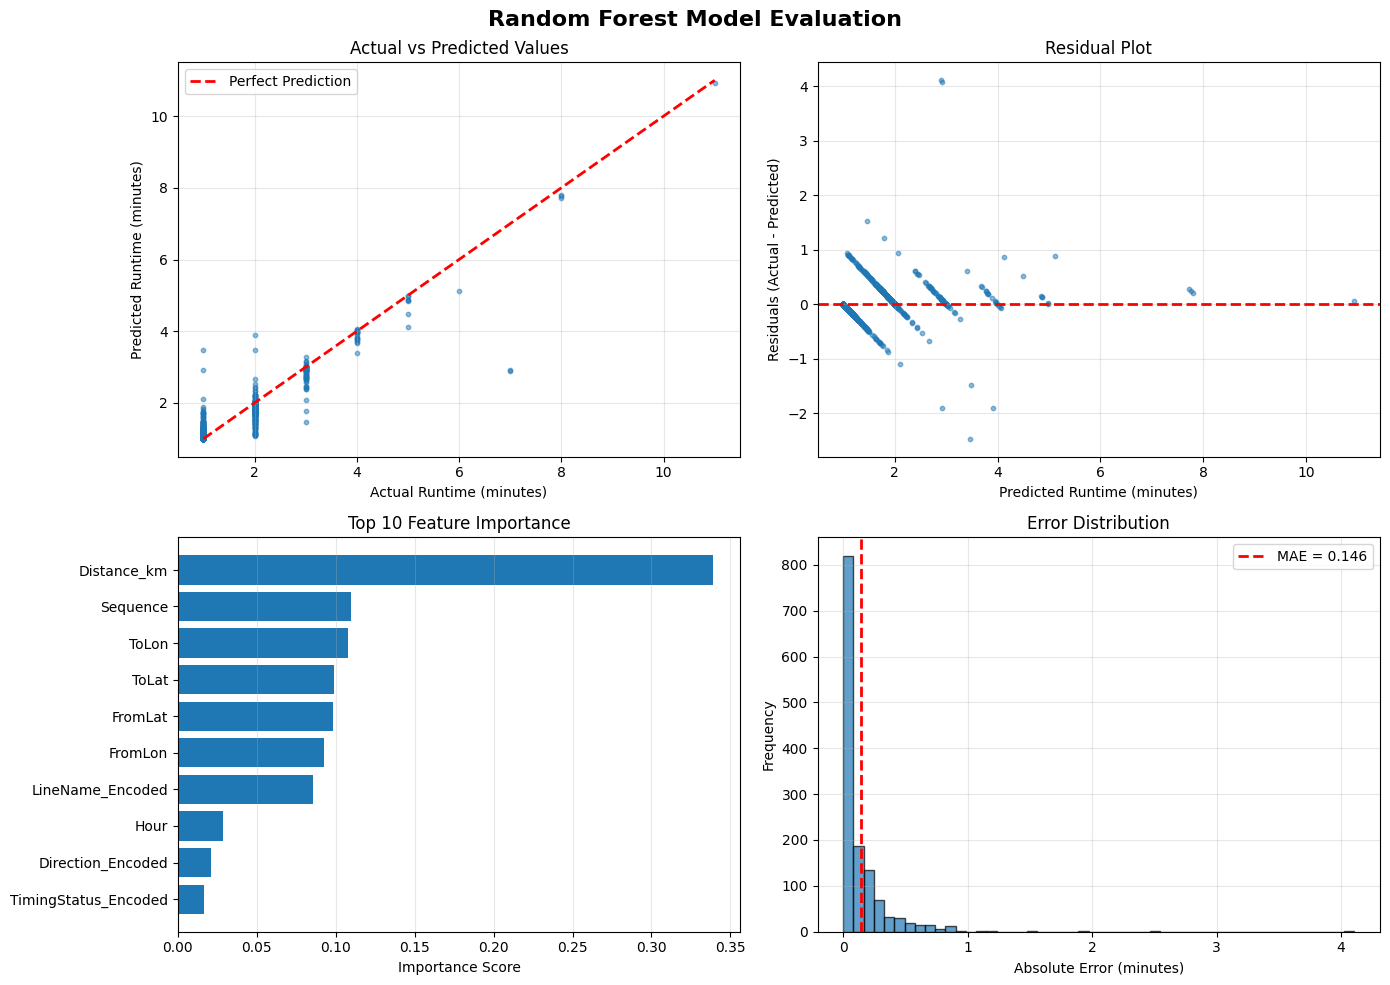


RANDOM FOREST MODEL SUMMARY

Model Type: Random Forest Regressor
Number of Trees: 100
Training Samples: 55605
Test Samples: 13668

PERFORMANCE METRICS:
  MAE:  0.1458 minutes (8.7 seconds)
  RMSE: 0.2920 minutes
  R²:   0.8792 (87.9% variance explained)
  
QUALITY: EXCELLENT

TOP 3 IMPORTANT FEATURES:
  1. Distance_km: 0.3393
  2. Sequence: 0.1094
  3. ToLon: 0.1075

Model is ready for predictions!



In [13]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("=" * 70)
print("RANDOM FOREST REGRESSOR - TRAINING & EVALUATION")
print("=" * 70)

# STEP 1: TRAIN-TEST SPLIT
print("\nStep 1: Splitting data into train and test sets...")
train_data, test_data = df_scaled.randomSplit([0.8, 0.2], seed=42)

train_count = train_data.count()
test_count = test_data.count()

print(f"Training set: {train_count} samples (80%)")
print(f"Test set: {test_count} samples (20%)")

# STEP 2: CREATE RANDOM FOREST MODEL
print("\nStep 2: Creating Random Forest model...")
rf = RandomForestRegressor(
    featuresCol='features',
    labelCol='RunTime_Minutes',
    numTrees=100,
    maxDepth=15,
    minInstancesPerNode=5,
    seed=42
)

print("Model configuration:")
print(f"  Number of trees: 100")
print(f"  Max depth: 15")
print(f"  Min instances per node: 5")

# STEP 3: TRAIN THE MODEL
print("\nStep 3: Training Random Forest model...")
print("(This may take 1-2 minutes...)")

rf_model = rf.fit(train_data)

print("Training complete!")
print(f"Feature importances calculated")

# STEP 4: MAKE PREDICTIONS
print("\nStep 4: Making predictions on test data...")
predictions = rf_model.transform(test_data)
print(f"Generated {test_count} predictions")

# STEP 5: EVALUATE MODEL
print("\n" + "=" * 70)
print("MODEL EVALUATION METRICS")
print("=" * 70)

evaluator_mae = RegressionEvaluator(
    labelCol='RunTime_Minutes',
    predictionCol='prediction',
    metricName='mae'
)

evaluator_rmse = RegressionEvaluator(
    labelCol='RunTime_Minutes',
    predictionCol='prediction',
    metricName='rmse'
)

evaluator_r2 = RegressionEvaluator(
    labelCol='RunTime_Minutes',
    predictionCol='prediction',
    metricName='r2'
)

mae = evaluator_mae.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"\nMean Absolute Error (MAE):  {mae:.4f} minutes")
print(f"Root Mean Squared Error:    {rmse:.4f} minutes")
print(f"R-Squared Score:            {r2:.4f}")

print(f"\nInterpretation:")
print(f"  Average prediction error: {mae:.3f} minutes ({mae*60:.1f} seconds)")
print(f"  Model explains {r2*100:.1f}% of the variance")

if mae < 0.2:
    quality = "EXCELLENT"
elif mae < 0.5:
    quality = "VERY GOOD"
elif mae < 1.0:
    quality = "GOOD"
else:
    quality = "MODERATE"

print(f"  Model quality: {quality}")

# STEP 6: SAMPLE PREDICTIONS
print("\n" + "=" * 70)
print("SAMPLE PREDICTIONS (First 10)")
print("=" * 70)

sample_predictions = predictions.select(
    'RunTime_Minutes',
    'prediction'
).limit(10).toPandas()

sample_predictions['Error'] = np.abs(sample_predictions['RunTime_Minutes'] - sample_predictions['prediction'])
sample_predictions.columns = ['Actual', 'Predicted', 'Error']

print("\n", sample_predictions.to_string(index=False))

# STEP 7: FEATURE IMPORTANCE
print("\n" + "=" * 70)
print("FEATURE IMPORTANCE")
print("=" * 70)

feature_names = feature_cols
importances = rf_model.featureImportances.toArray()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop features by importance:")
print(importance_df.to_string(index=False))

# STEP 8: VISUALIZATION
print("\n" + "=" * 70)
print("GENERATING EVALUATION PLOTS")
print("=" * 70)

plot_data = predictions.select('RunTime_Minutes', 'prediction').sample(False, 0.1, seed=42).toPandas()
plot_data.columns = ['Actual', 'Predicted']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Random Forest Model Evaluation', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted Scatter
ax1 = axes[0, 0]
ax1.scatter(plot_data['Actual'], plot_data['Predicted'], alpha=0.5, s=10)
ax1.plot([plot_data['Actual'].min(), plot_data['Actual'].max()], 
         [plot_data['Actual'].min(), plot_data['Actual'].max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Runtime (minutes)')
ax1.set_ylabel('Predicted Runtime (minutes)')
ax1.set_title('Actual vs Predicted Values')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals
ax2 = axes[0, 1]
residuals = plot_data['Actual'] - plot_data['Predicted']
ax2.scatter(plot_data['Predicted'], residuals, alpha=0.5, s=10)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Runtime (minutes)')
ax2.set_ylabel('Residuals (Actual - Predicted)')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

# Plot 3: Feature Importance
ax3 = axes[1, 0]
top_features = importance_df.head(10)
ax3.barh(range(len(top_features)), top_features['Importance'])
ax3.set_yticks(range(len(top_features)))
ax3.set_yticklabels(top_features['Feature'])
ax3.set_xlabel('Importance Score')
ax3.set_title('Top 10 Feature Importance')
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Error Distribution
ax4 = axes[1, 1]
errors = np.abs(plot_data['Actual'] - plot_data['Predicted'])
ax4.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax4.axvline(mae, color='r', linestyle='--', lw=2, label=f'MAE = {mae:.3f}')
ax4.set_xlabel('Absolute Error (minutes)')
ax4.set_ylabel('Frequency')
ax4.set_title('Error Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('random_forest_evaluation.png', dpi=300, bbox_inches='tight')
print("\nPlot saved as: random_forest_evaluation.png")
plt.show()

# STEP 9: SUMMARY
print("\n" + "=" * 70)
print("RANDOM FOREST MODEL SUMMARY")
print("=" * 70)

print(f"""
Model Type: Random Forest Regressor
Number of Trees: 100
Training Samples: {train_count}
Test Samples: {test_count}

PERFORMANCE METRICS:
  MAE:  {mae:.4f} minutes ({mae*60:.1f} seconds)
  RMSE: {rmse:.4f} minutes
  R²:   {r2:.4f} ({r2*100:.1f}% variance explained)
  
QUALITY: {quality}

TOP 3 IMPORTANT FEATURES:
  1. {importance_df.iloc[0]['Feature']}: {importance_df.iloc[0]['Importance']:.4f}
  2. {importance_df.iloc[1]['Feature']}: {importance_df.iloc[1]['Importance']:.4f}
  3. {importance_df.iloc[2]['Feature']}: {importance_df.iloc[2]['Importance']:.4f}

Model is ready for predictions!
""")

print("=" * 70)

## Prediction Model - Random Forest

In [15]:
print("=" * 70)
print("INTERACTIVE PREDICTION SYSTEM - RANDOM FOREST")
print("=" * 70)

# Get unique stops from data
stops_data = df_clean.select('FromStopName', 'FromLat', 'FromLon').distinct().limit(50).toPandas()
stops_dict = {row['FromStopName']: (row['FromLat'], row['FromLon']) 
              for _, row in stops_data.iterrows()}
stop_names = list(stops_dict.keys())

# Get unique routes
routes = df_clean.select('LineName').distinct().toPandas()['LineName'].tolist()

# Get encodings
route_encodings = {row['LineName']: row['LineName_Encoded'] 
                   for row in df_clean.select('LineName', 'LineName_Encoded').distinct().collect()}
direction_encodings = {row['Direction']: row['Direction_Encoded'] 
                       for row in df_clean.select('Direction', 'Direction_Encoded').distinct().collect()}

print("\nPrediction system ready!")
print(f"Available stops: {len(stop_names)}")
print(f"Available routes: {len(routes)}")

def make_prediction():
    print("\n" + "=" * 70)
    print("NEW JOURNEY PREDICTION")
    print("=" * 70)
    
    # Display stop options
    num_stops_to_show = 20 if len(stop_names) >= 20 else len(stop_names)
    print(f"\nAvailable stops (showing first {num_stops_to_show}):")
    for i, stop in enumerate(stop_names[:num_stops_to_show], 1):
        print(f"  {i}. {stop}")
    
    # Get user input
    print("\nEnter journey details:")
    from_stop_idx = int(input(f"From stop number (1-{num_stops_to_show}): ")) - 1
    to_stop_idx = int(input(f"To stop number (1-{num_stops_to_show}): ")) - 1
    
    from_stop = stop_names[from_stop_idx]
    to_stop = stop_names[to_stop_idx]
    
    # Display route options
    num_routes_to_show = 10 if len(routes) >= 10 else len(routes)
    print(f"\nAvailable routes:")
    for i, route in enumerate(routes[:num_routes_to_show], 1):
        print(f"  {i}. {route}")
    
    route_idx = int(input(f"Route number (1-{num_routes_to_show}): ")) - 1
    selected_route = routes[route_idx]
    
    # Direction
    print("\nDirection:")
    print("  1. inbound")
    print("  2. outbound")
    direction_choice = int(input("Choose (1 or 2): "))
    selected_direction = 'inbound' if direction_choice == 1 else 'outbound'
    
    # Time
    hour = int(input("\nHour (0-23): "))
    sequence = int(input("Stop sequence number (1-30): "))
    
    # Calculate distance
    from_coords = stops_dict[from_stop]
    to_coords = stops_dict[to_stop]
    
    import math
    
    def calculate_distance(lat1, lon1, lat2, lon2):
        R = 6371
        lat1_r, lon1_r = math.radians(lat1), math.radians(lon1)
        lat2_r, lon2_r = math.radians(lat2), math.radians(lon2)
        dlat = lat2_r - lat1_r
        dlon = lon2_r - lon1_r
        a = math.sin(dlat/2)**2 + math.cos(lat1_r) * math.cos(lat2_r) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        return R * c
    
    distance = calculate_distance(from_coords[0], from_coords[1], 
                                   to_coords[0], to_coords[1])
    
    # Determine rush hour
    is_rush_hour = 1 if (7 <= hour <= 9) or (16 <= hour <= 18) else 0
    
    # Create prediction data
    route_encoded = route_encodings.get(selected_route, 0)
    direction_encoded = direction_encodings.get(selected_direction, 0)
    
    new_journey = spark.createDataFrame([
        (route_encoded,
         direction_encoded,
         sequence,
         0,
         distance,
         hour,
         is_rush_hour,
         from_coords[0],
         from_coords[1],
         to_coords[0],
         to_coords[1])
    ], feature_cols)
    
    # Transform through pipeline
    new_journey_assembled = assembler.transform(new_journey)
    new_journey_scaled = scaler_model.transform(new_journey_assembled)
    
    # Make prediction
    prediction = rf_model.transform(new_journey_scaled)
    result = prediction.select('prediction').collect()[0][0]
    
    # Display results
    print("\n" + "=" * 70)
    print("PREDICTION RESULT")
    print("=" * 70)
    print(f"\nJourney Details:")
    print(f"  From: {from_stop}")
    print(f"  To: {to_stop}")
    print(f"  Route: {selected_route}")
    print(f"  Direction: {selected_direction}")
    print(f"  Time: {hour}:00")
    print(f"  Distance: {distance:.2f} km")
    print(f"  Rush Hour: {'Yes' if is_rush_hour else 'No'}")
    print(f"\n  PREDICTED RUNTIME: {result:.2f} minutes")
    print(f"  That's approximately {result*60:.0f} seconds")
    print("=" * 70)

# Run the interactive system
while True:
    make_prediction()
    
    continue_choice = input("\nMake another prediction? (y/n): ")
    if continue_choice.lower() != 'y':
        print("\nThank you for using the prediction system!")
        break

INTERACTIVE PREDICTION SYSTEM - RANDOM FOREST

Prediction system ready!
Available stops: 49
Available routes: 27

NEW JOURNEY PREDICTION

Available stops (showing first 20):
  1. Brighton Road (KT6)
  2. Windsor Street
  3. Park Way
  4. Murray Road
  5. Waterden Road
  6. Leisure Centre
  7. Banstead Crossroads
  8. College Drive
  9. The Black Prince
  10. Meadowlands Park
  11. All Saints Church Clarence St
  12. The Woodlands
  13. Southway Shops
  14. Dartnell Park Road
  15. Westfield Road
  16. Hunting Close
  17. Wolsey Road
  18. Brooklands Road
  19. Sandown Park
  20. Henslow Way

Enter journey details:


From stop number (1-20):  1
To stop number (1-20):  5



Available routes:
  1. 714
  2. 479
  3. 28
  4. 663
  5. 456
  6. 615
  7. 461
  8. 437
  9. 81
  10. 515


Route number (1-10):  3



Direction:
  1. inbound
  2. outbound


Choose (1 or 2):  1

Hour (0-23):  4
Stop sequence number (1-30):  5


[Stage 151:>                                                        (0 + 8) / 8]


PREDICTION RESULT

Journey Details:
  From: Brighton Road (KT6)
  To: Waterden Road
  Route: 28
  Direction: inbound
  Time: 4:00
  Distance: 24.31 km
  Rush Hour: No

  PREDICTED RUNTIME: 4.40 minutes
  That's approximately 264 seconds



Make another prediction? (y/n):  n



Thank you for using the prediction system!
